<a href="https://colab.research.google.com/github/subhabrata-ghosh-1988/Transformers/blob/main/Transformers_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ensembles of Transformer Models


In [5]:
## Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import os
import random
import torch
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
!pip install transformers
import transformers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
## Data seeding
def set_seed(seed):
        # For reproducibility
        os.environ['PYTHONHASHSEED']=str(seed)
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [7]:
## For reproducibility
set_seed(42)

### 01. Data Loading

In [8]:
df = pd.read_json("https://raw.githubusercontent.com/subhabrata-ghosh-1988/Transformers/main/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
df.drop('article_link', axis=1, inplace=True)

### 02. Data pre-processing

In [10]:
## Listing stopword and punctuations
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [12]:
## Get the corpus from the headlines
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [13]:
## Get the most common words after the stop word removals
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'area': 494,
 'day': 435,
 'donald': 472,
 'like': 428,
 'man': 1351,
 'new': 1637,
 'one': 527,
 'says': 482,
 'trump': 1284,
 'woman': 483}

In [14]:
## Split the data into dependent and independent variables (X,Y)
X = df['headline']
y = df['is_sarcastic']

In [15]:
# Train/ Test split for model training
X_data = df[['headline']].to_numpy().reshape(-1)
y_data = df[['is_sarcastic']].to_numpy().reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) 
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_data, y_data, test_size=0.3, random_state=777) 

### 03. Model building


*   Encode the model input
*   Load the model from the disk
*   Check the accuarcy for the loaded models



In [16]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [17]:
## Encoding using the tokenizers
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [18]:
## Encoding for the BERT and DistilBERT models
x_train = fast_encode(X_train, fast_tokenizer, maxlen=400)
x_test = fast_encode(X_test, fast_tokenizer, maxlen=400)

In [19]:
## Libraries for download model(.h5) files
from keras.models import model_from_json
from transformers import BertTokenizer, TFBertModel
!pip install gdown
import gdown

#### 03.01 BERT

In [20]:
## Download BERT models and weights
gdown.download("https://drive.google.com/uc?id=1ts6wzpqycSCab92xK8PR8-BOHLrwesCi")
gdown.download("https://drive.google.com/uc?id=15VXuCEgsHdJ09ZCgAFfJzHYMWzti1bDC")

Downloading...
From: https://drive.google.com/uc?id=1ts6wzpqycSCab92xK8PR8-BOHLrwesCi
To: /content/bert-model.json
100%|██████████| 3.13k/3.13k [00:00<00:00, 3.13MB/s]
Downloading...
From: https://drive.google.com/uc?id=15VXuCEgsHdJ09ZCgAFfJzHYMWzti1bDC
To: /content/bert-model.h5
100%|██████████| 438M/438M [00:04<00:00, 108MB/s]


'bert-model.h5'

In [21]:
# load json and create model
json_file = open('bert-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_bert = model_from_json(loaded_model_json,custom_objects={'TFBertModel': TFBertModel})
# load weights into new model
loaded_model_bert.load_weights("bert-model.h5")
print("Loaded model from drive")

Loaded model from drive


In [22]:
## Complie the BERT model
loaded_model_bert.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    

In [23]:
print("Accuracy of the BERT model on Testing Data is - " , loaded_model_bert.evaluate(x_test,y_test)[1]*100 , "%")

269/269 [==============================] - 464s 2s/step - loss: 0.1339 - accuracy: 0.9548
Accuracy of the BERT model on Testing Data is -  95.48101425170898 %


In [24]:
## Predict the test lables for input
bert_uncased_pred = loaded_model_bert.predict(x_test)

#### 03.02 DistilBERT

In [25]:
## Download DistilBERT models
gdown.download("https://drive.google.com/uc?id=1Zz8u68-3I7_WZ3puMuHW7Gb7aYXy0icJ")
gdown.download("https://drive.google.com/uc?id=1FIeuaCmkSGKMVTUWyaHe25Zp3--6ToL5")

Downloading...
From: https://drive.google.com/uc?id=1Zz8u68-3I7_WZ3puMuHW7Gb7aYXy0icJ
To: /content/distil-bert-model.h5
100%|██████████| 266M/266M [00:02<00:00, 92.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FIeuaCmkSGKMVTUWyaHe25Zp3--6ToL5
To: /content/distil-bert-model.json
100%|██████████| 3.04k/3.04k [00:00<00:00, 5.23MB/s]


'distil-bert-model.json'

In [26]:
from keras.models import model_from_json
from transformers import BertTokenizer, TFBertModel,TFDistilBertModel

In [27]:
# load json and create model
json_file = open('distil-bert-model.json', 'r')
distil_bert_loaded_model_json = json_file.read()
json_file.close()
distil_bert_loaded_model = model_from_json(distil_bert_loaded_model_json,custom_objects={'TFDistilBertModel': TFDistilBertModel})
# load weights into new model
distil_bert_loaded_model.load_weights("distil-bert-model.h5")
print("Loaded model from disk")

Loaded model from disk


In [28]:
## Compile the models
distil_bert_loaded_model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    

In [29]:
## Accuracy of the DistilBERT model
print("Accuracy of the DistilBERT model on Testing Data is - " , distil_bert_loaded_model.evaluate(x_test,y_test)[1]*100 , "%")

269/269 [==============================] - 231s 843ms/step - loss: 0.1443 - accuracy: 0.9465
Accuracy of the DistilBERT model on Testing Data is -  94.6540892124176 %


In [30]:
## Predict the output classes for the test data
distil_bert_uncased_pred=distil_bert_loaded_model.predict(x_test)

#### 03.03 RoBERTa

In [31]:
## Download RoBERTa model
gdown.download("https://drive.google.com/uc?id=1i5sAvxSHn0nJSbDBJt_fFo5odNr3mfpn")
gdown.download("https://drive.google.com/uc?id=1mFKQokVJxysXmeyjxRhinjxiiNKT3DXG")

Downloading...
From: https://drive.google.com/uc?id=1i5sAvxSHn0nJSbDBJt_fFo5odNr3mfpn
To: /content/roberta-model.h5
100%|██████████| 700M/700M [00:06<00:00, 107MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mFKQokVJxysXmeyjxRhinjxiiNKT3DXG
To: /content/roberta-model.json
100%|██████████| 4.18k/4.18k [00:00<00:00, 2.13MB/s]


'roberta-model.json'

In [32]:
## RoBERTa model for the input
from keras.models import model_from_json
from transformers import BertTokenizer, TFBertModel,TFRobertaModel

In [33]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [34]:
MODEL_NAME = 'roberta-base'
# MAX_LEN= 256
MAX_LEN= 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [35]:
## Encoding for the RoBERTa model
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [36]:
# load json and create model
json_file = open('roberta-model.json', 'r')
roberta_loaded_model_json = json_file.read()
json_file.close()
roberta_loaded_model = model_from_json(roberta_loaded_model_json,custom_objects={'TFRobertaModel': TFRobertaModel})
# load weights into new model
roberta_loaded_model.load_weights("roberta-model.h5")
print("Loaded model from disk")

Loaded model from disk


In [37]:
## Model compile
roberta_loaded_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [38]:
## Model tokenizer
from transformers import RobertaTokenizer, TFRobertaModel
r_tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [39]:
## Encoding the input
X_train_r = roberta_encode(X_train_r, r_tokenizer)
X_test_r = roberta_encode(X_test_r, r_tokenizer)

## Converting the numpy array to output
y_train_r = np.asarray(y_train_r, dtype='int32')
y_test_r = np.asarray(y_test_r, dtype='int32')

In [40]:
## Accuracy of the model on TEST data
print("Accuracy of the model on Testing Data is - " , roberta_loaded_model.evaluate(X_test_r, y_test_r)[1]*100 , "%")

269/269 [==============================] - 275s 996ms/step - loss: 1.1808 - accuracy: 0.6971
Accuracy of the model on Testing Data is -  69.7064995765686 %


In [41]:
## RoBERT a output labels
roberta_pred =  roberta_loaded_model.predict(X_test_r)

### 04. Ensemble models

#### 04.01 Bagging Ensembles

In [42]:
## Bagging Ensembles - Taking the mean of the probabilities
mean_pred = np.mean([bert_uncased_pred,roberta_pred,distil_bert_uncased_pred], axis=0)

In [43]:
## Checking the mean labels
mean_pred

array([[0.9963336 ],
       [0.9948712 ],
       [0.3014773 ],
       ...,
       [0.80797035],
       [0.0256226 ],
       [0.36823806]], dtype=float32)

In [44]:
## Change the labels
mean_pred = np.round(mean_pred).astype(int)

In [45]:
## The confusion matrix
print(classification_report(y_test, mean_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4458
           1       0.94      0.97      0.95      4128

    accuracy                           0.96      8586
   macro avg       0.96      0.96      0.96      8586
weighted avg       0.96      0.96      0.96      8586



In [57]:
cm = confusion_matrix(y_test, mean_pred)
cm

array([[4208,  250],
       [ 130, 3998]])

Text(69.0, 0.5, 'Actual')

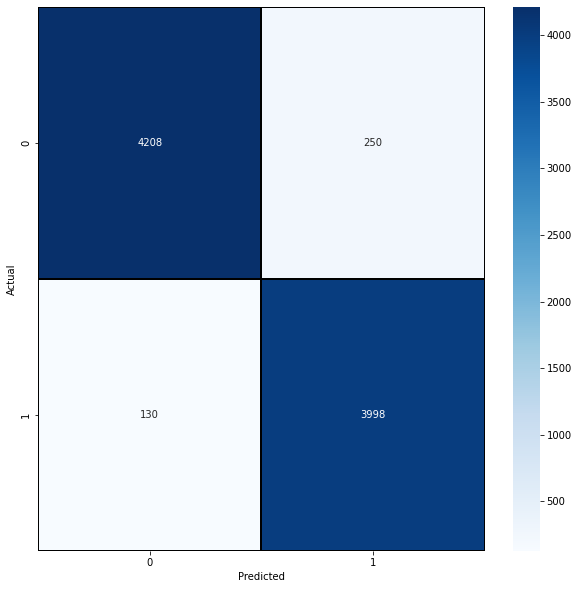

In [58]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

#### 04.02 Voting Ensembles

In [46]:
## Voting ensembles
import scipy
distil_bert_uncased_pred_n=np.round(distil_bert_uncased_pred).astype(int)
roberta_pred_n = np.round(roberta_pred).astype(int)
bert_uncased_pred_n = np.round(bert_uncased_pred).astype(int)
voting_labels = np.concatenate((distil_bert_uncased_pred_n,roberta_pred_n,bert_uncased_pred_n),axis=1)
voting_labels = scipy.stats.mode(voting_labels, axis=1)[0] ## Taking the mode of the labels out of three probabilities
voting_labels = np.squeeze(voting_labels)
voting_labels.shape

(8586,)

In [47]:
## Confusion Matrix after voting ensembles
print(classification_report(y_test, voting_labels))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4458
           1       0.94      0.96      0.95      4128

    accuracy                           0.95      8586
   macro avg       0.95      0.95      0.95      8586
weighted avg       0.95      0.95      0.95      8586



In [55]:
cm = confusion_matrix(y_test, voting_labels)
cm

array([[4226,  232],
       [ 159, 3969]])

Text(69.0, 0.5, 'Actual')

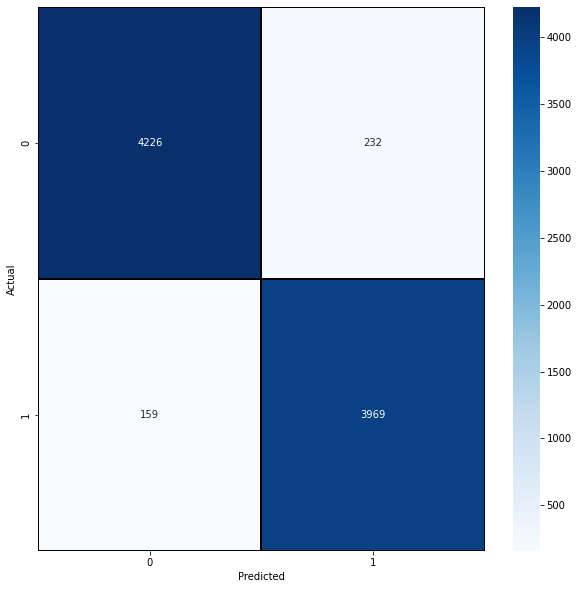

In [56]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

#### 04.03 Stacking Ensembles

In [48]:
## Stacking ensembles - Logistics Regression as Meta Model
stackX = np.dstack((distil_bert_uncased_pred,roberta_pred,bert_uncased_pred))
stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))

In [49]:
## Stack on the model outputs
stackX

array([[9.9123114e-01, 1.0000000e+00, 9.9776971e-01],
       [9.8470968e-01, 9.9999988e-01, 9.9990416e-01],
       [4.7303354e-03, 8.9722216e-01, 2.4794224e-03],
       ...,
       [8.0600500e-01, 7.7809530e-01, 8.3981079e-01],
       [3.1381545e-03, 7.3076263e-02, 6.5338885e-04],
       [1.4341101e-02, 9.9938190e-01, 9.0991147e-02]], dtype=float32)

In [50]:
## Create a Meta model as logistics regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(stackX, y_test)

LogisticRegression()

In [51]:
## Accuarcy of logistics regression
yhat = model.predict(stackX)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.958


In [52]:
## Confusion Matrix
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4458
           1       0.96      0.95      0.96      4128

    accuracy                           0.96      8586
   macro avg       0.96      0.96      0.96      8586
weighted avg       0.96      0.96      0.96      8586



In [53]:
cm = confusion_matrix(y_test, yhat)
cm

array([[4287,  171],
       [ 192, 3936]])

Text(69.0, 0.5, 'Actual')

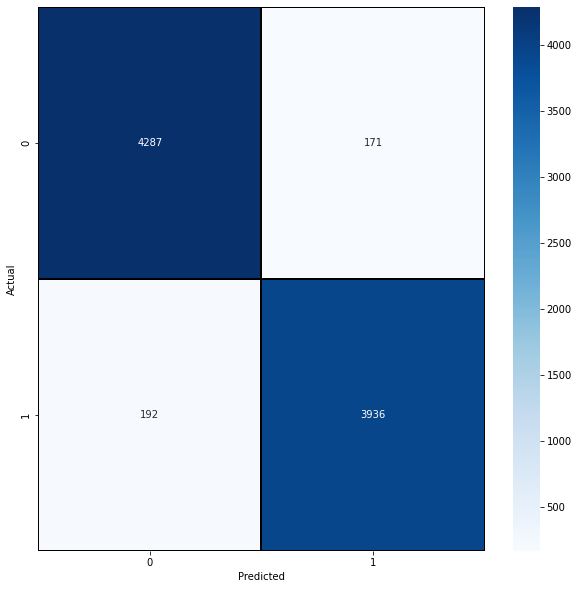

In [54]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")